Data Preprocessing 

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder, HashingEncoder

df = pd.read_csv('Clean_Dataset.csv')
one_hot = OneHotEncoder()
target = TargetEncoder()
hash = HashingEncoder(n_components=16)


airline_encoded = one_hot.fit_transform(df[["airline"]]).toarray()
airline_labels =  [f"airline_{cat}" for cat in one_hot.categories_[0]]
airline_df = pd.DataFrame(airline_encoded, columns=airline_labels)

source_encoded = one_hot.fit_transform(df[["source_city"]]).toarray()
source_labels = [f"source_{cat}" for cat in one_hot.categories_[0]]
source_df = pd.DataFrame(source_encoded, columns=source_labels)

destination_encoded = one_hot.fit_transform(df[["destination_city"]]).toarray()
destination_labels = [f"destination_{cat}" for cat in one_hot.categories_[0]]
destination_df = pd.DataFrame(destination_encoded, columns=destination_labels)

#flight_encoded = hash.fit_transform(df['flight'])

df["departure_time"]= target.fit_transform(df['departure_time'], df['price'])
df["arrival_time"]= target.fit_transform(df['arrival_time'], df['price'])

df['stops'] = df['stops'].map({'zero':0, 'one':1, 'two_or_more':2})
df['class'] = df['class'].map({'Economy':0, 'Business':1})

new_df = pd.concat([df, airline_df, source_df, destination_df], axis=1)
new_df = new_df.drop(["Unnamed: 0", "flight", "airline", "source_city", "destination_city"], axis=1)
new_df = new_df.astype('float32')



Splitting Data for Future Prediction

In [2]:
future_df = new_df.tail(15)
training_df = new_df.iloc[:-15]

Random Selection

In [3]:
import random

# Group columns into categories
airline_columns = airline_df.columns.tolist()
source_columns = source_df.columns.tolist()
destination_columns = destination_df.columns.tolist()
#flight_columns = flight_encoded.columns.tolist()

# Add groups to a list
groups = {
    "airline": airline_columns,
    "source_city": source_columns,
    "destination_city": destination_columns,
    #"flight": flight_columns,
}

# Flatten the remaining individual columns in `new_df`
individual_columns = [
    col
    for col in training_df.columns
    if col not in airline_columns + source_columns + destination_columns #+ flight_columns
]
individual_columns.remove("price")

# Combine groups with individual columns for selection
all_features = list(groups.keys()) + individual_columns

# Randomly select 5 features
select_features = random.sample(all_features, 5)

# Expand selected features into their full groups if necessary
final_features = []
for feature in select_features:
    if feature in groups:  # If the feature is a group, include all its columns
        final_features.extend(groups[feature])
    else:  # Otherwise, it's an individual column
        final_features.append(feature)

# Create a new DataFrame with the selected features
selected_features = training_df[final_features]

# Print selected features
print("Selected features:", [
        feature if feature in groups else feature for feature in select_features])

Selected features: ['class', 'source_city', 'days_left', 'destination_city', 'arrival_time']


Dataset Splitting

In [4]:
from sklearn.model_selection import train_test_split

x = selected_features  
y = training_df['price']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

Model 1: XGBoost

**XGBOOST Model Evaluation**

-Accuracy: 0.9120
-MAE (Mean Absolute Error): 3911.1494
-RMSE: 6717.0420
-R²: 0.9120


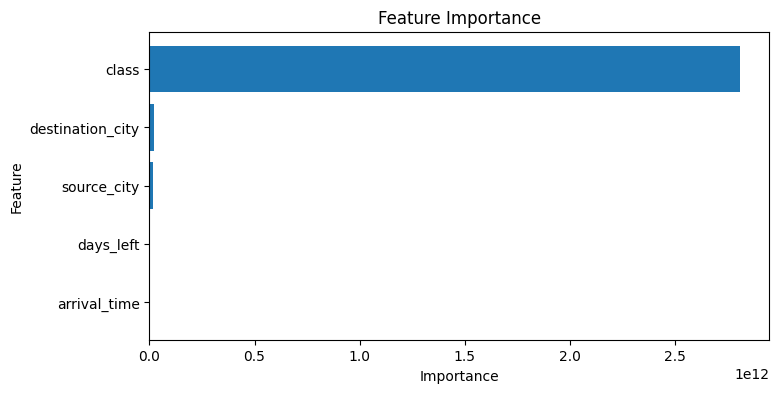

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# Initialize the XGBoost regressor
xgb_model = XGBRegressor(
    n_estimators=100,       # Number of trees
    max_depth=6,            # Maximum depth of trees
    learning_rate=0.1,      # Learning rate
    subsample=0.8,          # Subsampling ratio
    colsample_bytree=0.8,   # Feature subsampling ratio per tree
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on the test set
xg_pred = xgb_model.predict(X_test)

# Evaluate the model
xg_acc = xgb_model.score(X_test, y_test)
xg_mae = mean_absolute_error(y_test, xg_pred)
xg_rmse = np.sqrt(mean_squared_error(y_test, xg_pred))
xg_r2 = r2_score(y_test, xg_pred)

print("**XGBOOST Model Performance Evaluation**\n")
print(f"-Accuracy: {xg_acc:.4f}")
print(f"-MAE (Mean Absolute Error): {xg_mae:.4f}")
print(f"-RMSE (Root Mean Squared Error): {xg_rmse:.4f}")
print(f"-R² (R-Squared): {xg_r2:.4f}")

# Retrieve feature importances
booster = xgb_model.get_booster()
feature_importance = booster.get_score(importance_type='gain')

# Convert to a DataFrame for easier manipulation
importance_df = pd.DataFrame(
    feature_importance.items(),
    columns=['Feature', 'Importance']
)

# Define mappings for encoded columns
group_mapping = {
    "airline": [col for col in airline_columns if col in selected_features],
    "source_city": [col for col in source_columns if col in selected_features],
    "destination_city": [col for col in destination_columns if col in selected_features],
    #"flight": [col for col in flight_encoded.columns.tolist() if col in selected_features],
}

# Add individual columns to the mapping
for col in individual_columns:
    if col in selected_features:
        group_mapping[col] = [col]

for group_name in list(group_mapping.keys()):
    group_mapping[group_name] = [col for col in group_mapping[group_name] if col in selected_features]
    
    # If the group is empty after filtering, remove it from the mapping
    if not group_mapping[group_name]:
        del group_mapping[group_name]

# Initialize a dictionary to hold aggregated importance
group_importance = {}

for group_name, columns in group_mapping.items():
    # Filter importance_df for columns in the current group
    group_importance[group_name] = importance_df[
        importance_df['Feature'].isin(columns)]['Importance'].sum()

# Convert to a DataFrame for visualization
aggregated_importance_df = pd.DataFrame(
    group_importance.items(),
    columns=['Feature', 'Aggregated Importance']
).sort_values(by='Aggregated Importance', ascending=False) 

# Plot aggregated feature importances
plt.figure(figsize=(8, 4))
plt.barh(
    aggregated_importance_df['Feature'],
    aggregated_importance_df['Aggregated Importance']
)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert the y-axis to display the highest importance at the top
plt.show()

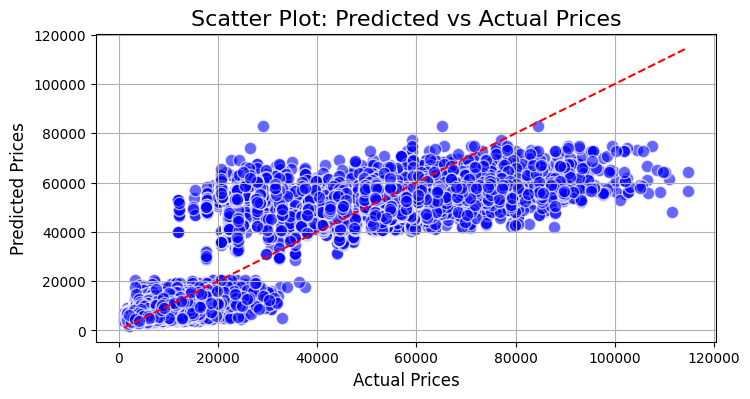

In [ ]:
import seaborn as sns

plt.figure(figsize=(8,4))
plt.scatter(y_test, xg_pred, color = 'blue', alpha=0.6, edgecolors='w', s=80)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')

# Labeling the axes
plt.title("XGBOOST Scatter Plot: Predicted vs Actual Prices", fontsize=16)
plt.xlabel("Actual Prices", fontsize=12)
plt.ylabel("Predicted Prices", fontsize=12)

# Show the plot
plt.grid(True)
plt.show()

Model 2: Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sn 

random_forest = RandomForestClassifier(n_estimators=5, max_depth=10,
    max_features='log2',
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42)

random_forest.fit(X_train, y_train)

random_pred = random_forest.predict(X_test)

random_accuracy = random_forest.score(X_test, y_test)
random_mae = mean_absolute_error(y_test, random_pred)
random_rmse = np.sqrt(mean_squared_error(y_test, random_pred))
random_r2 = r2_score(y_test, random_pred)

print("**Random Forest Model Performance Evaluation**\n")
print(f"-Accuracy: {random_accuracy:.4f}")
print(f"-MAE (Mean Absolute Error): {random_mae:.4f}")
print(f"-RMSE (Root Mean Squared Error): {random_rmse:.4f}")
print(f"-R² (R-Squared): {random_r2:.4f}")



**Random Forest Model Performance Evaluation**

-Accuracy: 0.2249
-MAE (Mean Absolute Error): 4248.5928
-RMSE (Root Mean Squared Error): 8072.5244
-R² (R-Squared): 0.8729


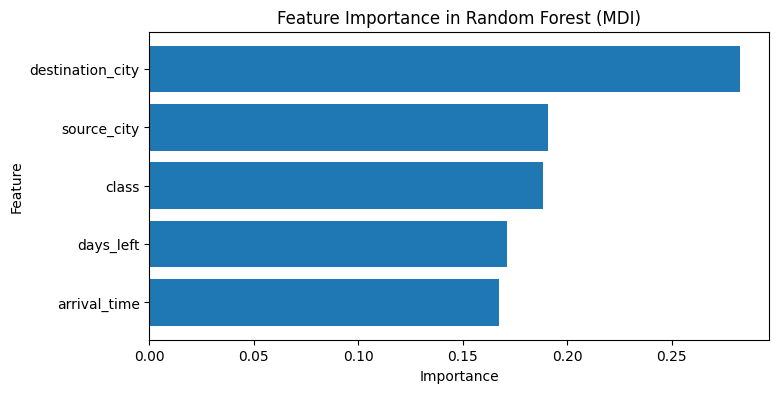

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'random_forest' is your trained RandomForest model
# Get feature importances (Mean Decrease Impurity)
feature_importance = random_forest.feature_importances_

# Convert to a DataFrame for easier manipulation
importance_df = pd.DataFrame(
    list(zip(training_df[final_features].columns, feature_importance)),
    columns=['Feature', 'Importance']
)

# Define mappings for encoded columns
group_mapping = {
    "airline": [col for col in airline_columns if col in selected_features],
    "source_city": [col for col in source_columns if col in selected_features],
    "destination_city": [col for col in destination_columns if col in selected_features],
    #"flight": [col for col in flight_encoded.columns.tolist() if col in selected_features],
}

# Add individual columns to the mapping
for col in individual_columns:
    if col in selected_features:
        group_mapping[col] = [col]

for group_name in list(group_mapping.keys()):
    group_mapping[group_name] = [col for col in group_mapping[group_name] if col in selected_features]
    
    # If the group is empty after filtering, remove it from the mapping
    if not group_mapping[group_name]:
        del group_mapping[group_name]

# Initialize a dictionary to hold aggregated importance
group_importance = {}

for group_name, columns in group_mapping.items():
    # Filter importance_df for columns in the current group
    group_importance[group_name] = importance_df[importance_df['Feature'].isin(columns)]['Importance'].sum()

# Convert to a DataFrame for visualization
aggregated_importance_df = pd.DataFrame(
    group_importance.items(),
    columns=['Feature', 'Aggregated Importance']
).sort_values(by='Aggregated Importance', ascending=False)

# Plot aggregated feature importances
plt.figure(figsize=(8, 4))
plt.barh(
    aggregated_importance_df['Feature'],
    aggregated_importance_df['Aggregated Importance']
)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest')
plt.gca().invert_yaxis()  # Invert the y-axis to display the highest importance at the top
plt.show()


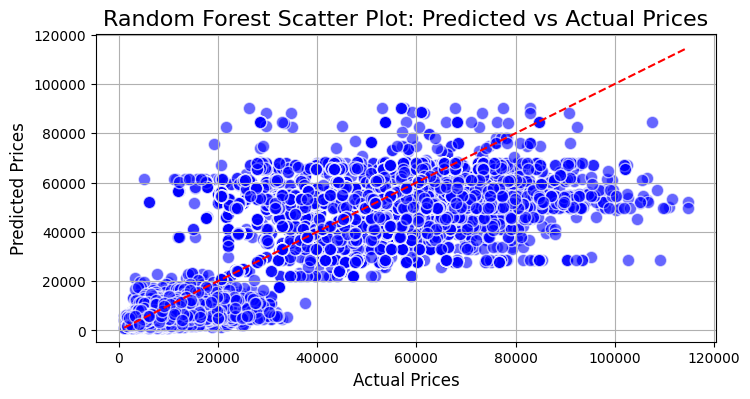

In [33]:
plt.figure(figsize=(8,4))
plt.scatter(y_test, random_pred, color = 'blue', alpha=0.6, edgecolors='w', s=80)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')

# Labeling the axes
plt.title("Random Forest Scatter Plot: Predicted vs Actual Prices", fontsize=16)
plt.xlabel("Actual Prices", fontsize=12)
plt.ylabel("Predicted Prices", fontsize=12)

# Show the plot
plt.grid(True)
plt.show()

Model 3: ANN 

In [8]:
from keras.models import Sequential
from keras.layers import Dense

# Create the model
ann_model = Sequential([
    Dense(64, activation="relu", input_dim=X_train.shape[1]),
    Dense(32, activation="relu"),
    Dense(1, activation="linear")  # Linear activation for regression
])

# Compile the model with mean squared error loss
ann_model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

# Fit the model
ann_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Evaluate the model on the test set
ann_accuracy = ann_model.evaluate(X_test, y_test, verbose=0)[1]
print(f"ANN Mean Absolute Error: {ann_accuracy:.4f}")



c:\Users\fhuba\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
6566/6566 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 516706848.0000 - mae: 19390.0996
Epoch 2/10
6261/6566 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 505390176.0000 - mae: 19438.1250

KeyboardInterrupt: 

XGBoost k-fold cross validation:

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Number of folds
k = 5

# Initialize KFold
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize lists to store metrics for each fold
rmse_list = []
r2_list = []

# Perform k-fold cross-validation
for train_index, test_index in kf.split(x):
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the model
    xgb_model = XGBRegressor(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    xgb_model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = xgb_model.predict(X_test)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Append metrics
    rmse_list.append(rmse)
    r2_list.append(r2)

# Calculate average and standard deviation of metrics
avg_rmse = np.mean(rmse_list)
std_rmse = np.std(rmse_list)
avg_r2 = np.mean(r2_list)
std_r2 = np.std(r2_list)

# Print the results
print(f"K-Fold Cross-Validation Results (k={k}):")
print(f"Average RMSE: {avg_rmse:.4f} ± {std_rmse:.4f}")
print(f"Average R²: {avg_r2:.4f} ± {std_r2:.4f}")


ANN k-fold cross validation:

In [ ]:
from sklearn.model_selection import KFold
import numpy as np
from keras.models import Sequential
from keras.layers import Dense

# Number of folds
k = 5

# Initialize KFold
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize lists to store metrics for each fold
mae_list = []

# Define a function to create the ANN model
def create_ann_model(input_dim):
    model = Sequential([
        Dense(64, activation="relu", input_dim=input_dim),
        Dense(32, activation="relu"),
        Dense(1, activation="linear")  # Linear activation for regression
    ])
    model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])
    return model

# Perform k-fold cross-validation
for train_index, test_index in kf.split(x):
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Create and train the model
    model = create_ann_model(input_dim=X_train.shape[1])
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    # Evaluate the model on the test set
    mae = model.evaluate(X_test, y_test, verbose=0)[1]
    mae_list.append(mae)

# Calculate average and standard deviation of MAE
avg_mae = np.mean(mae_list)
std_mae = np.std(mae_list)

# Print the results
print(f"K-Fold Cross-Validation Results (k={k}):")
print(f"Average MAE: {avg_mae:.4f} ± {std_mae:.4f}")
